In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(data.table)
library(ggplot2)
library(ggalluvial)
library(pheatmap)
library(RColorBrewer)
library(GenomicRanges)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

### this is just to resize jupyter notebook plot size
library(repr)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching pac

In [5]:
### reproduce bedtools intersect -wao
intersect_wao <- function(grA, grB, ignore.strand = TRUE) {
  # all overlaps
  hits <- findOverlaps(grA, grB, ignore.strand = ignore.strand)
  q <- queryHits(hits); s <- subjectHits(hits)

  ov <- pintersect(ranges(grA)[q], ranges(grB)[s])
  ovlen <- width(ov)

  A_df <- as.data.frame(grA[q])
  B_df <- as.data.frame(grB[s])
  out_hits <- cbind(A_df, B_df, overlap_len = ovlen, row.names = NULL)

  has_hit <- logical(length(grA))
  has_hit[unique(q)] = TRUE
  nohit_idx <- which(!has_hit)

  if (length(nohit_idx)) {
    A0_df <- as.data.frame(grA[nohit_idx])
    if (nrow(out_hits)) {
      B0_df <- as.data.frame(grB[0])                # empty -> right colnames
      B0_df[seq_len(nrow(A0_df)), ] <- NA           # fill with NA rows
    } else {
      B0_df <- data.frame(seqnames = NA, start = NA, end = NA, strand = NA)
    }
    out_nohits <- cbind(A0_df, B0_df, overlap_len = 0L, row.names = NULL)
    out <- rbind(out_hits, out_nohits)
  } else {
    out <- out_hits
  }

  if (nrow(out)) {
    if (!"start" %in% names(out)) return(out) # safety
    # recover A order using an index saved in mcols if you want; simpler sort by seqnames/start
    out <- out[order(out$seqnames, out$start, out$end), , drop = FALSE]
  }
  out
}

In [2]:
corder <- read.table("./analysis/04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("./analysis/04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

In [6]:
rmeta <- read.csv("./analysis/04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')

In [402]:
flist <- list()
i=1

outdir <- "/projects/ps-renlab2/y2xie/projects/BICAN/analysis/10.chromhmm/output/"
for (file in list.files(paste0(outdir, "/comparemodel/DNAme_50pct"), pattern = ".txt")){
    bsize = gsub("([^_]+)_([^_]+).txt", "\\1", file)
    nstate = gsub("([^_]+)_([^_]+).txt", "\\2", file)
    tmp <- read.table(paste0(outdir, "/comparemodel/DNAme_50pct/", file), header = T) %>% setNames(c("state", "cor"))
    flist[[i]] <- data.frame(cor = median(tmp$cor), nstate = nstate, bsize = bsize)
    i = i + 1
}

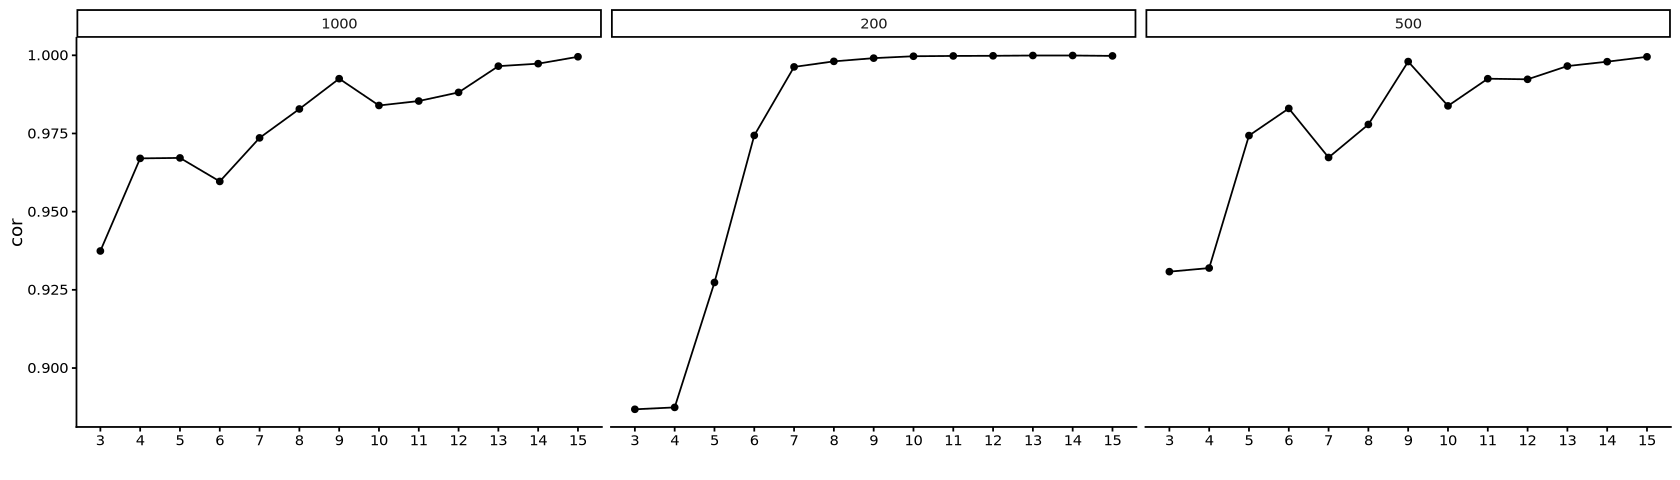

In [403]:
options(repr.plot.width = 14, repr.plot.height = 4)
do.call(rbind, flist) %>%
ggplot(aes(x = as.integer(nstate), y = cor, group = bsize)) + 
geom_point() + 
geom_line() + xlab("") + 
scale_x_continuous(breaks = seq(3, 16, 1)) + 
theme_classic() + 
facet_grid(. ~ bsize)

### Choose state number 10

### Check chromhmm sparsity using different bins

In [20]:
chmm <- list()
for (bsize in c(200, 500, 1000)){
    for (f in list.files(paste0(outdir, "/", bsize, "_9"), pattern = ".*_9_segments.bed.gz")){
        fname = gsub("_9_segments.bed.gz", "", f)
        chmm[[paste0(fname, "_", bsize)]] <- read.table(paste0(outdir, "/", bsize, "_9/", f)) %>% 
        mutate(length = V3 - V2) %>%
        group_by(V4) %>%
        summarise(size = sum(length)) %>%
        ungroup() %>%
        mutate(celltype = fname, binsize = bsize)
    }
}

chmm <- do.call(rbind, chmm)

Warning message:
“Removed 78 rows containing non-finite outside the scale range (`stat_boxplot()`).”


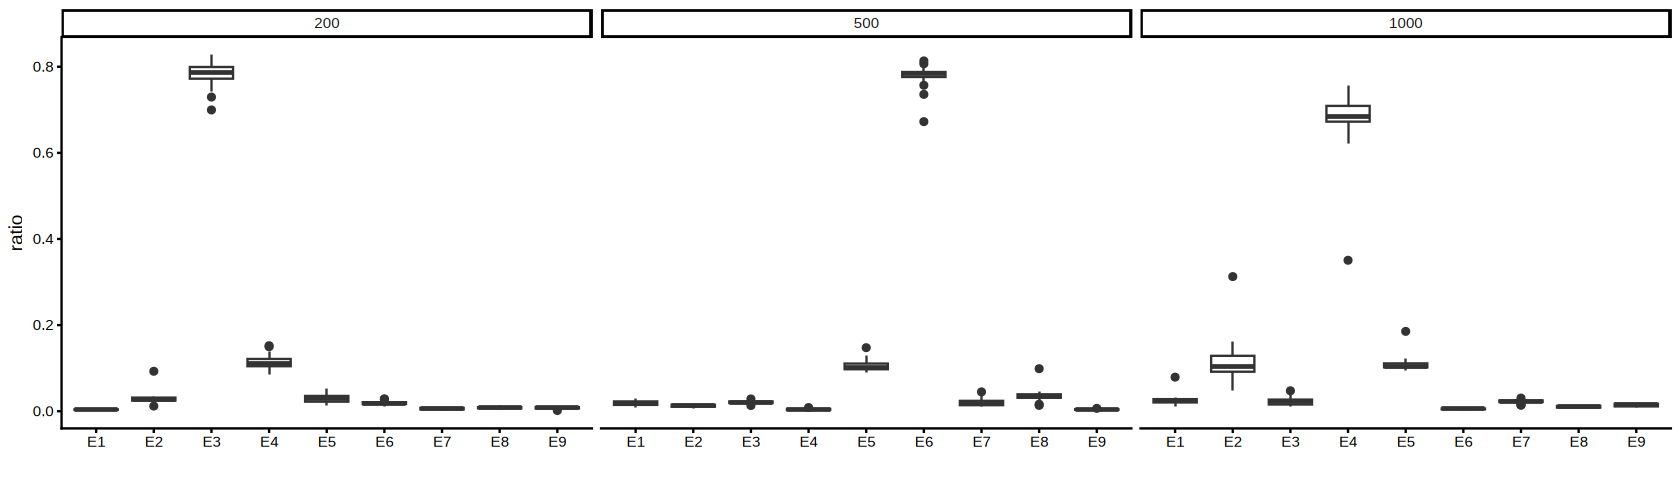

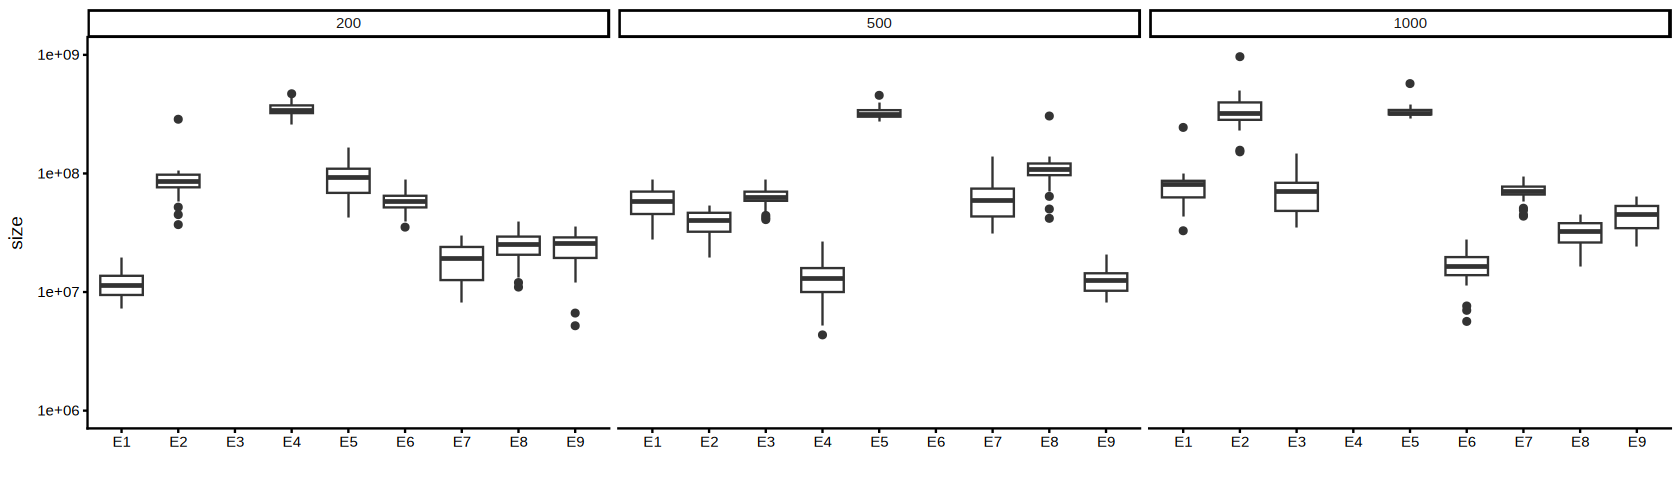

In [28]:
options(repr.plot.width = 14, repr.plot.height = 4)
chmm %>%
group_by(celltype, binsize) %>%
mutate(ratio = size / sum(size)) %>%
ungroup() %>%
ggplot(aes(x = V4, y = ratio)) + 
geom_boxplot() + xlab("") + 
theme_classic() + 
facet_grid(. ~ binsize)

chmm %>%
group_by(celltype, binsize) %>%
ungroup() %>%
ggplot(aes(x = V4, y = size)) + 
geom_boxplot() + xlab("") + 
theme_classic() + scale_y_log10(limits = c(10^6, 10^9)) + 
facet_grid(. ~ binsize)

### Choose binsize 200 since it is not too empty

## Find best state number

In [5]:
flist <- list()
i=1

outdir <- "./analysis/10.chromhmm/output/"
for (file in list.files(paste0(outdir, "/comparemodel/DNAme_hyper"), pattern = ".txt")){
    bsize = gsub("([^_]+)_([^_]+).txt", "\\1", file)
    nstate = gsub("([^_]+)_([^_]+).txt", "\\2", file)
    tmp <- read.table(paste0(outdir, "/comparemodel/DNAme_hyper/", file), header = T) %>% setNames(c("state", "cor")) %>%
    mutate(, nstate = nstate, bsize = bsize)
    flist[[i]] <- tmp
    i = i + 1
}

flist <- do.call(rbind, flist)

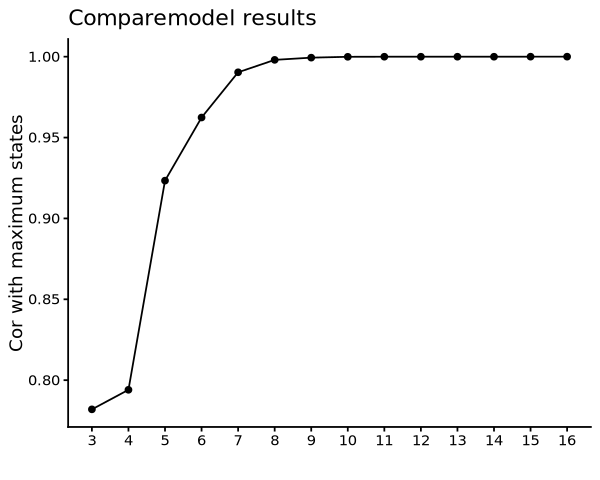

In [89]:
flist <- flist %>% group_by(nstate) %>% summarise(cor = median(cor))
ldf <- data.frame(nstate = 16, cor = 1)

t1 <- rbind(flist, ldf) %>%
ggplot(aes(x = as.integer(nstate), y = cor, group = bsize)) + 
geom_point() + 
geom_line() + xlab("") + 
scale_x_continuous(breaks = seq(3, 16, 1)) + 
ggtitle("Comparemodel results") + ylab("Cor with maximum states") + 
theme_classic() # + facet_grid(. ~ bsize)

options(repr.plot.width = 5, repr.plot.height = 4)
t1
### Choose state number 8 - 10

In [ ]:
### use kmeans method as described in Gorkin 2020 Nature to determine best res
chmm <- list()
for (f in list.files(paste0(outdir, "DNAme_hyperCGN/"), pattern = "^200_.*")){
    nstate <- gsub(".*_([^_]+)", "\\1", f)
    chmm[[f]] <- read.table(paste0(outdir, "DNAme_hyperCGN/", f, "/emissions_", nstate, ".txt"), sep = "\t", header = T) %>%
    mutate(nstate = f)
}
chmm <- do.call(rbind, chmm) %>% mutate(state = paste0(nstate, ":", State..Emission.order.))

qmat <- chmm[,c(2,3,4,5,7)]
rownames(qmat) <- qmat$state
qmat$state <- NULL
head(qmat)

In [ ]:
set.seed(921) 
k_range <- 3:16
n_realizations <- 500

ratio_mat <- sapply(
  k_range,
  function(k) {
    ratios <- replicate(
      n_realizations,
      {
        km <- kmeans(scale(qmat), centers = k, nstart = 50, iter.max = 100)
        km$betweenss / km$totss
      }
    )
    data.frame(mean(ratios), median(ratios))  # average ratio for this k
  }
)

ratio_mat[] <- lapply(ratio_mat, function(x) as.numeric(unlist(x)))
ratio_mat <- t(ratio_mat) %>% as.data.frame
rownames(ratio_mat) <- k_range

qcol <- 'mean.ratios.'
ratio_max <- ratio_mat['16', qcol]               
threshold      <- 0.9 * (ratio_max) %>% as.numeric
k_opt <- min(k_range[ratio_mat[, qcol] >= threshold])  

cat(sprintf("Optimal number of states: k = %d\n", k_opt))

t1 <- data.frame(k_range = k_range, ratio_mat = unlist(ratio_mat[, qcol])) %>%
ggplot(aes(x = as.integer(k_range), y = ratio_mat, group = bsize)) + 
geom_point() + 
geom_line() + 
geom_hline(yintercept = threshold) +
xlab("") + 
scale_x_continuous(breaks = seq(3, 16, 1)) + 
ggtitle("kmeans results (mean)") + ylab("Between SS / Total SS (mean over 100 runs)") + 
theme_classic() # + facet_grid(. ~ bsize)

qcol <- 'median.ratios.'
ratio_max <- ratio_mat['16', qcol]               
threshold      <- 0.9 * (ratio_max) %>% as.numeric
k_opt <- min(k_range[ratio_mat[, qcol] >= threshold])  

cat(sprintf("Optimal number of states: k = %d\n", k_opt))

t2 <- data.frame(k_range = k_range, ratio_mat = unlist(ratio_mat[, qcol])) %>%
ggplot(aes(x = as.integer(k_range), y = ratio_mat, group = bsize)) + 
geom_point() + 
geom_line() + 
geom_hline(yintercept = threshold) +
xlab("") + 
scale_x_continuous(breaks = seq(3, 16, 1)) + 
ggtitle("kmeans results (median)") + ylab("Between SS / Total SS (mean over 100 runs)") + 
theme_classic() # + facet_grid(. ~ bsize)

options(repr.plot.width = 10, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)

In [129]:
ggsave(fig1, filename = "../Figure/FIG_chromhmm_w_hyperscore_model_kmeans.pdf", dpi = 300, width = 12, height = 5)

ratio_mat <- data.frame(mean.ratios. = unlist(ratio_mat[, 'mean.ratios.']), median.ratios. = unlist(ratio_mat[, 'median.ratios.']))
write.table(ratio_mat, "../Figure/FIG_chromhmm_w_hyperscore_model_kmeans.txt", row.names = F, col.names = T, sep = "\t", quote = F)

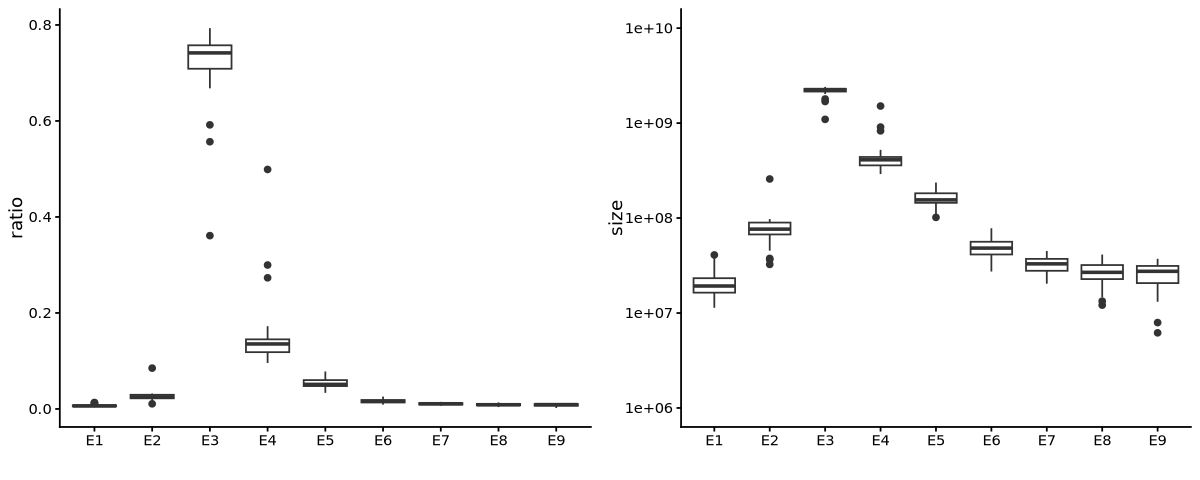

In [488]:
chmm <- list()
bsize = 200
bestres = 9
for (f in list.files(paste0(outdir, "/DNAme_hyperCGN/", bsize, "_", bestres), pattern = ".*_segments.bed.gz")){
    fname = gsub("_segments.bed.gz", "", f)
    chmm[[paste0(fname, "_", bsize)]] <- read.table(paste0(outdir, "/DNAme_hyperCGN/", bsize, "_", bestres, "/", f)) %>% 
    mutate(length = V3 - V2) %>%
    group_by(V4) %>%
    summarise(size = sum(length)) %>%
    ungroup() %>%
    mutate(celltype = fname, binsize = bsize)
}

chmm <- do.call(rbind, chmm)

t1 <- chmm %>%
group_by(celltype, binsize) %>%
mutate(ratio = size / sum(size)) %>%
ungroup() %>%
ggplot(aes(x = V4, y = ratio)) + 
geom_boxplot() + xlab("") + 
theme_classic() # + facet_grid(. ~ binsize)

t2 <- chmm %>%
group_by(celltype, binsize) %>%
ungroup() %>%
ggplot(aes(x = V4, y = size)) + 
geom_boxplot() + xlab("") + 
theme_classic() + scale_y_log10(limits = c(10^6, 10^10))

options(repr.plot.width = 10, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, ncol = 2)

### Filter bad bins: posterior prob < 0.5

In [566]:
suppressPackageStartupMessages({
  library(data.table)
  library(matrixStats)
  library(parallel)
})

valid_ids <- fread("binary/valid.celltype", header = FALSE)[[1]]
base_dir  <- "output/DNAme_hyperCGN/segmentation/POSTERIOR"
all_files <- list.files(base_dir, pattern = "posterior\\.txt\\.gz$", full.names = TRUE)
chroms    <- c(paste0("chr", 1:22), "chrX")

MC_CORES <- 12
FREAD_THR <- 2
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1")
data.table::setDTthreads(1)  # avoid oversubscription inside workers

is_numish <- function(x) is.numeric(x) || is.integer(x) || is.logical(x)

process_chrom <- function(chrom) {
  files_chr <- all_files[grepl(paste0("_", chrom, "_posterior\\.txt\\.gz$"), all_files)]
  if (!length(files_chr)) return(data.frame(PF=logical(0), chr=chrom))

  vec_list <- lapply(files_chr, function(f) {
    dt <- fread(f, sep = "\t", header = TRUE, skip = 1, nThread = FREAD_THR, showProgress = FALSE)

    # keep only numeric / integer / logical columns
    cols <- which(vapply(dt, is_numish, TRUE))
    if (!length(cols)) stop("No numeric/integer/logical columns in: ", f)
    X <- as.matrix(dt[, ..cols])

    # if all logical -> use rowAnys; else coerce to double and rowMaxs
    if (is.logical(X)) {
      rowAnys(X)                                   # TRUE if any >= 1
    } else {
      storage.mode(X) <- "double"                  # coerces int/logical to double
      rowMaxs(X) >= 0.5
    }
  })

  mat <- do.call(cbind, vec_list)
  colnames(mat) <- sub("_posterior\\.txt\\.gz$", "", basename(files_chr))

  keep <- intersect(paste0(valid_ids, "_9_", chrom), colnames(mat))
  if (!length(keep)) return(data.frame(PF = rep(FALSE, nrow(mat)), chr = chrom))

  PF <- rowMeans(mat[, keep, drop = FALSE]) > 0.9   # fraction ≥0.5 across valid IDs
  data.frame(PF = PF, chr = chrom, stringsAsFactors = FALSE)
}

res_list <- mclapply(chroms, process_chrom, mc.cores = MC_CORES)

In [568]:
finfo <- do.call(rbind, lapply(res_list, function(x) table(x$PF) %>% as.data.frame))
finfo$chr <- rep(unlist(lapply(res_list, function(x) unique(x$chr))), each = 2)
finfo %>% group_by(chr) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>% filter(Var1 == TRUE) %>%
dplyr::select(ratio) %>% summary

     ratio       
 Min.   :0.9585  
 1st Qu.:0.9667  
 Median :0.9684  
 Mean   :0.9683  
 3rd Qu.:0.9698  
 Max.   :0.9752  

In [569]:
write.table(finfo, "output/DNAme_hyperCGN/bin200_filter_posterior_05.summary", row.names = F, col.names = T, sep = "\t", quote = F)

In [570]:
### add bin info
bin_size <- 200
chrom_sizes <- fread("/projects/ps-renlab2/y2xie/projects/genome_ref/hg38.main.chrom.sizes", header = FALSE)
colnames(chrom_sizes) <- c("chr", "size")

bins_list <- lapply(seq_len(nrow(chrom_sizes)), function(i) {
    chr <- chrom_sizes$chr[i]
    chr_len <- chrom_sizes$size[i]
    starts <- seq(1, chr_len, by = bin_size)
    ends <- pmin(starts + bin_size - 1, chr_len)  # cap at chromosome end
    
    GRanges(seqnames = chr, ranges = IRanges(start = starts, end = ends))
})

# Combine all chromosomes
bins <- lapply(bins_list, function(bins) data.frame(
    seqnames = seqnames(bins),
    start = start(bins) - 1, 
    end = end(bins)
))

In [571]:
validlist <- list()
for (i in 1:length(res_list)){
    qdf1 <- res_list[[i]]
    qdf2 <- bins[[i]]
    validlist[[i]] <- cbind(qdf2, qdf1)
}

saveRDS(validlist, "output/DNAme_hyperCGN/bin200_filter_posterior_05.rds")

In [572]:
### write to filter segmentation
fbin <- do.call(rbind, validlist) %>%
filter(PF == TRUE) %>%
mutate(start = as.integer(start), end = as.integer(end))
write.table(fbin[,1:3], "output/DNAme_hyperCGN/bin200_filter_posterior_05.bed", row.names = F, col.names = F, sep = "\t", quote = F)

In [573]:
gc()

used      (Mb)   gc trigger (Mb)   max used   (Mb)  
Ncells   6913312  369.3  15212141   812.5   15212141  812.5
Vcells 422446082 3223.1 835841863  6377.0 1043191827 7959.0

## Annotation of chromatin states

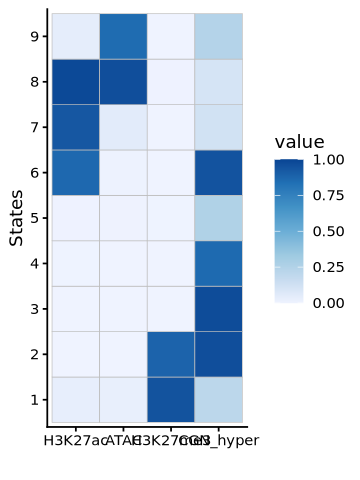

In [411]:
ems <- read.table(paste0(outdir, "/DNAme_hyperCGN/", bsize, "_9/emissions_9.txt"), sep = "\t", header = T) 
t1 <- ems %>%
reshape2::melt(id = 'State..Emission.order.') %>%
ggplot(aes(x = variable, y = as.character(State..Emission.order.), fill = value)) + 
geom_tile(color = "grey") + xlab("") + ylab("States") + 
theme_classic() +
scale_fill_distiller(palette = 'Blues', direction = 1, limits = c(0, 1))

options(repr.plot.width = 3, repr.plot.height = 4)
t1

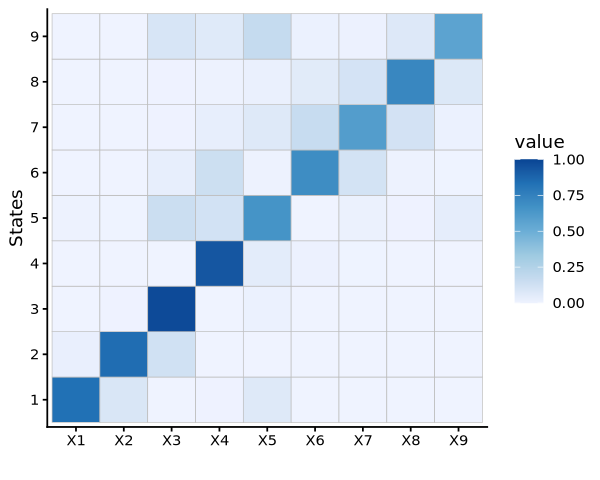

In [447]:
tran <- read.table(paste0(outdir, "/DNAme_hyperCGN/", bsize, "_9/transitions_9.txt"), sep = "\t", header = T) 
t1 <- tran %>%
reshape2::melt(id = 'State..from.to...Emission.order.') %>%
ggplot(aes(x = variable, y = as.character(State..from.to...Emission.order.), fill = value)) + 
geom_tile(color = "grey") + xlab("") + ylab("States") + 
theme_classic() +
scale_fill_distiller(palette = 'Blues', direction = 1, limits = c(0, 1))

options(repr.plot.width = 5, repr.plot.height = 4)
t1

In [303]:
### Plot enrichment: calculated using filtered bins
### minmax norm 
minmax <- function(x){
    (x-min(x))/(max(x) - min(x))
}
# qenrich <- read.table(paste0(outdir, "/DNAme_hyperCGN/enrichment/refdata-cellranger-GRCh38.p13_v43_region_ovlp.txt"), sep = "\t", header = T) 
# qenrich <- qenrich[1:9,] %>% tibble::column_to_rownames('State..Emission.order.')

qenrich <- list()
for (f in list.files(paste0(outdir, "/DNAme_hyperCGN/enrichment/filter"), pattern = ".txt")){
    fname <- gsub("_9_segments.txt", "", f)
    tmp <- read.table(paste0(outdir, "/DNAme_hyperCGN/enrichment/filter/", f), sep = "\t", header = T) 
    qenrich[[fname]] <- tmp[1:9,] %>% tibble::column_to_rownames('State..Emission.order.')
}
qenrich <- Reduce("+", qenrich) / length(qenrich)
nqenrich <- apply(qenrich, 2, minmax) %>% as.data.frame

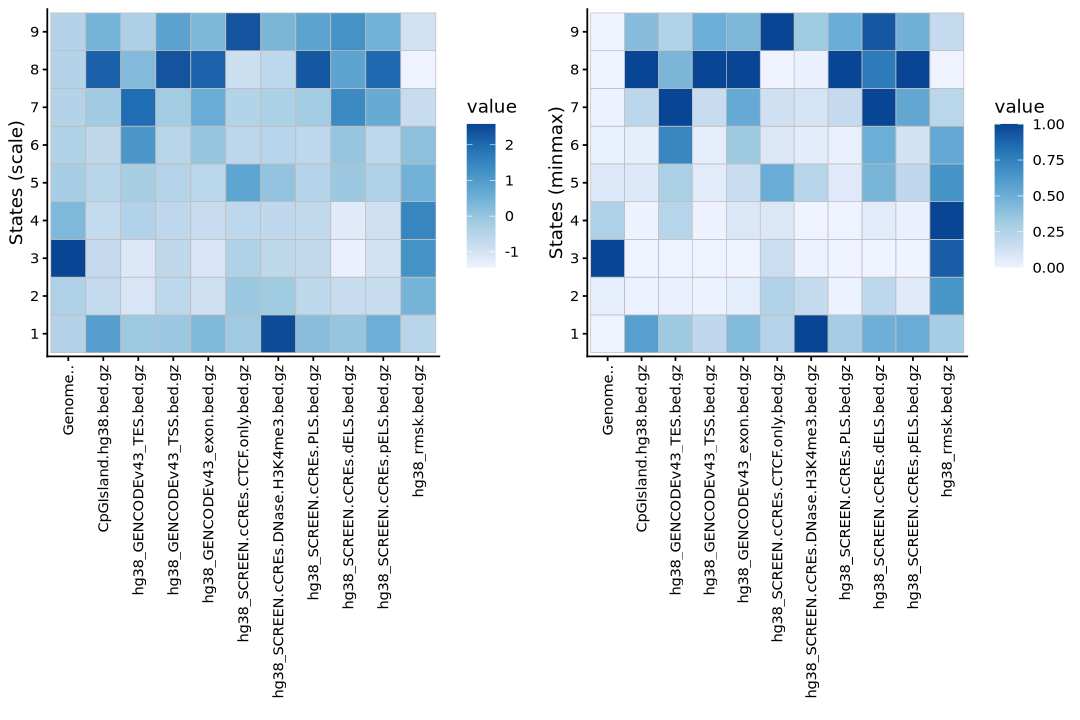

In [374]:
gtp <- c("Genome..", "CpGIsland.hg38.bed.gz", 'hg38_GENCODEv43_TSS.bed.gz', 'hg38_GENCODEv43_exon.bed.gz', "hg38_GENCODEv43_TES.bed.gz", 
        'hg38_SCREEN.cCREs.CTCF.only.bed.gz', 'hg38_SCREEN.cCREs.DNase.H3K4me3.bed.gz', 'hg38_SCREEN.cCREs.PLS.bed.gz', 
         'hg38_SCREEN.cCREs.dELS.bed.gz', 'hg38_SCREEN.cCREs.pELS.bed.gz', 'hg38_rmsk.bed.gz')
t1 <- as.data.frame(scale(nqenrich)) %>% tibble::rownames_to_column("state") %>%
reshape2::melt(id.vars = 'state') %>%
filter(variable %in% gtp) %>%
ggplot(aes(x = variable, y = as.character(state), fill = value)) + 
geom_tile(color = "grey") + xlab("") + ylab("States (scale)") + 
theme_classic() +
scale_fill_distiller(palette = 'Blues', direction = 1) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

t2 <- nqenrich %>% tibble::rownames_to_column("state") %>%
reshape2::melt(id.vars = 'state') %>%
filter(variable %in% gtp) %>%
ggplot(aes(x = variable, y = as.character(state), fill = value)) + 
geom_tile(color = "grey") + xlab("") + ylab("States (minmax)") + 
theme_classic() +
scale_fill_distiller(palette = 'Blues', direction = 1, limits = c(0, 1)) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width = 9, repr.plot.height = 6)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

In [15]:
chmstate <- data.frame(state = paste0("E", 1:9),
anno = c("1_ReprPC", "2_ReprPCWk", "3_Quies", "4_Het", "5_Inactive", "6_Active-3", "7_Active-2", "8_Active", "9_Open"),
color = c('#e7977c', '#bcb769', '#eeeeee', '#8b90c7', '#d4d7ff', '#8cc7e5', '#36aad6', '#0077a9', '#008349'))

library(grDevices)
rgb_colors <- sapply(chmstate$color, function(x) {
  paste(col2rgb(x), collapse = ",")
})
chmstate$rgb <- as.data.frame(rgb_colors)[,1]

In [537]:
### Plot bad bins removed coverage
chmm <- list()
bsize = 200
bestres = 9
for (f in list.files(paste0(outdir, "DNAme_hyperCGN/segmentation/filter/"), pattern = ".*_9_segments.bed")){
    fname = gsub("_9_segments.bed", "", f)
    chmm[[paste0(fname, "_", bsize)]] <- read.table(paste0(outdir, "/DNAme_hyperCGN/segmentation/filter/", f)) %>% 
    mutate(length = V3 - V2) %>%
    group_by(V4) %>%
    summarise(size = sum(length)) %>%
    ungroup() %>%
    mutate(celltype = fname, binsize = bsize)
}

chmm <- do.call(rbind, chmm)

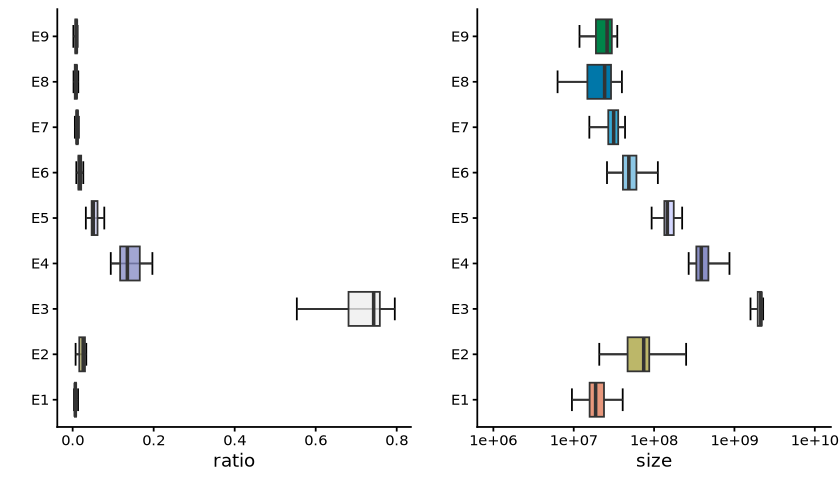

In [542]:
t1 <- chmm %>%
group_by(celltype, binsize) %>%
mutate(ratio = size / sum(size)) %>%
ungroup() %>%
ggplot(aes(x = V4, y = ratio, fill = V4)) + 
stat_boxplot(geom = "errorbar", width = 0.5, coef = 2) +
geom_boxplot(alpha = 0.8, coef = 2, outlier.shape = NA) + 
xlab("") + coord_flip() + 
scale_fill_manual(values = chmstate$color) + 
theme_classic() + NoLegend()

t2 <- chmm %>%
group_by(celltype, binsize) %>%
ungroup() %>%
ggplot(aes(x = V4, y = size, fill = V4)) + 
stat_boxplot(geom = "errorbar", width = 0.5, coef = 2) +
geom_boxplot(alpha = 1, coef = 2, outlier.shape = NA) + 
xlab("")  + 
scale_y_log10(limits = c(10^6, 10^10)) + 
coord_flip() + 
theme_classic() + 
scale_fill_manual(values = chmstate$color) + NoLegend()

options(repr.plot.width = 7, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
fig1

## Overlap with Epigenome Roadmap

In [7]:
### ENCODE states
# E010: H9 Derived Neuron Cultured Cells
# E072: Brain Inferior Temporal Lobe
# E073: Brain_Dorsolateral_Prefrontal_Cortex
suppressPackageStartupMessages(library(GenomicRanges))
e072 <- read.table("/projects/ps-renlab2/y2xie/projects/public_data/17.Epigenome_roadmap/mnemonics/E072_18_core_K27ac_mnemonics.hg38.bed")
e073 <- read.table("/projects/ps-renlab2/y2xie/projects/public_data/17.Epigenome_roadmap/mnemonics/E073_18_core_K27ac_mnemonics.hg38.bed")

rrange1 <- GRanges(e072[,1], ranges = IRanges(e072[,2], e072[,3]), state = e072[,4])
rrange2 <- GRanges(e073[,1], ranges = IRanges(e073[,2], e073[,3]), state = e073[,4])

In [24]:
query <- read.table("output/DNAme_hyperCGN/segmentation/filter/L23IT_9_segments.bed")
qrange <- GRanges(query[,1], ranges = IRanges(query[,2], query[,3]), state = query[,4])
ovlp1 <- intersect_wao(qrange, rrange1) %>%
setNames(c("chrom1", "start1", "end1", "size1", "strand1", "state1", "chrom2", "start2", "end2", "size2", "strand2", "state2", "len")) %>% 
filter(len > 0)

obs_mat <- ovlp1 %>%
group_by(state1, state2) %>%
summarise(tlen = sum(len)) %>%
ungroup %>%
reshape2::dcast(state1 ~ state2, value.var = "tlen") %>%
tibble::column_to_rownames("state1")

`summarise()` has grouped output by 'state1'. You can override using the
`.groups` argument.


In [27]:
### Plot OvE
genome_gr <- reduce(c(qrange, rrange1))
G <- sum(width(genome_gr))
sizeA <- tapply(width(qrange), qrange$state, sum)
sizeB <- tapply(width(rrange1), rrange1$state, sum)

exp_mat <- outer(
  sizeA / G,
  sizeB,
  FUN = "*"
)

head(exp_mat)

1_TssA      10_EnhA2   11_EnhWk   12_ZNF/Rpts 13_Het     14_TssBiv 
E1    82352.32   240502.7   222046.6   64359.26    553700.3   15448.60
E2   407514.84  1190111.2  1098782.4  318477.36   2739947.8   76446.32
E3 11909164.18 34779664.0 32110683.4 9307143.87  80071902.0 2234057.96
E4  2294377.33  6700526.7  6186330.4 1793081.33  15426368.6  430405.68
E5   983970.15  2873598.1  2653079.0  768983.58   6615775.9  184584.44
E6   203572.86   594516.6   548893.6  159094.44   1368733.0   38188.54
   15_EnhBiv   16_ReprPC 17_ReprPCWk 18_Quies   2_TssFlnk   3_TssFlnkU
E1    7178.482   68364.5   1037211      8662692    70432.26   48005.01
E2   35522.228  338297.1   5132569     42866739   348529.20  237549.52
E3 1038097.291 9886352.1 149993582   1252732376 10185375.12 6942118.48
E4  199996.142 1904669.5  28897232    241346976  1962278.25 1337443.92
E5   85770.649  816839.5  12392911    103504431   841545.63  573578.23
E6   17745.026  168995.3   2563960     21413955   174106.75  118667.18
   4_TssFlnkD 5_Tx       6_TxWk    7_EnhG1    8_EnhG2    9_EnhA1   
E1   33345.19   394909.5   1950012   61490.84   15240.49   130362.5
E2  165006.41  1954182.5   9649503  304283.21   75416.54   645089.8
E3 4822127.20 57108793.8 281995909 8892335.57 2203963.74 18852027.0
E4  929013.92 11002377.7  54328332 1713165.83  424607.84  3631964.7
E5  398418.32  4718496.4  23299331  734710.90  182097.96  1557609.9
E6   82428.47   976206.2   4820381  152003.79   37674.11   322252.8

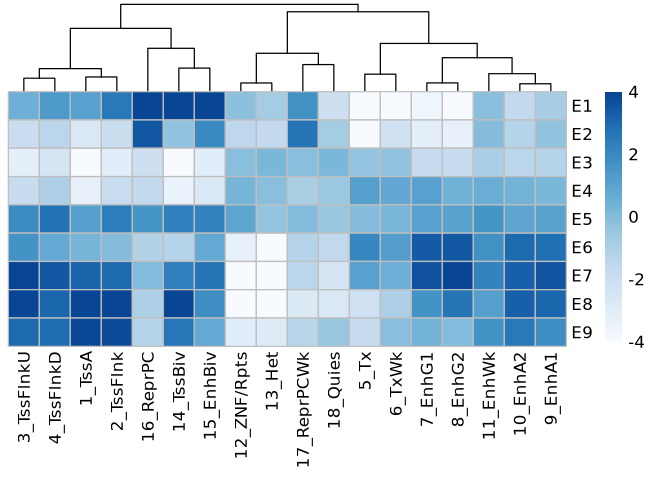

In [35]:
log2OE <- log2((obs_mat + 1) / (exp_mat + 1))
log2OE %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = T, display_numbers = F,
         angle_col = 90, breaks = seq(-4, 4, 0.08), 
         show_rownames = T, show_colnames = T, border_color = "grey", 
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(100))

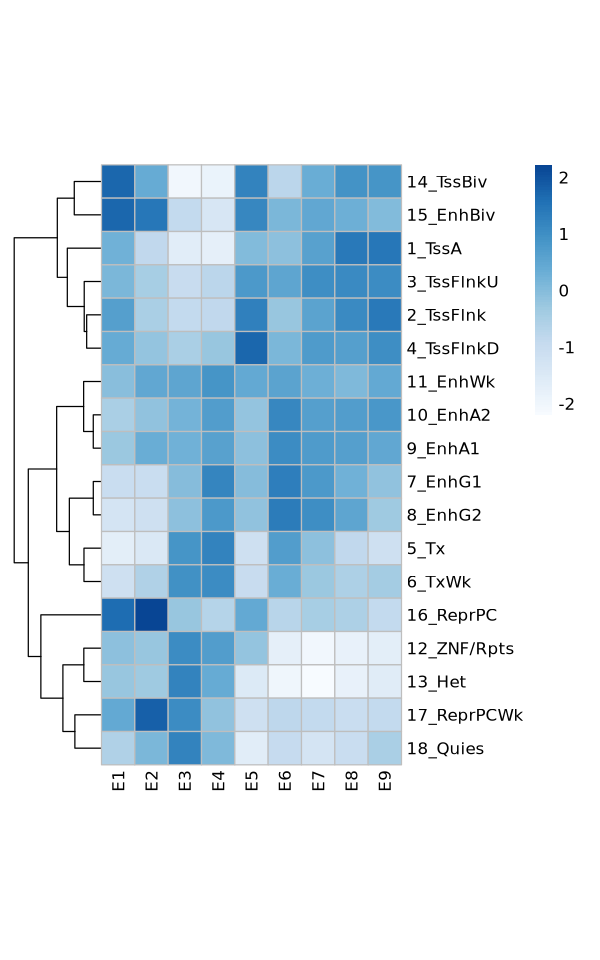

In [43]:
### row scale
options(repr.plot.width = 5, repr.plot.height = 8)
t1 <- t(scale(t(log2OE))) %>% t %>%
pheatmap(scale = "none", cluster_rows = T, cluster_cols = F, display_numbers = F,
         angle_col = 90, # breaks = seq(-4, 4, 0.08), 
         cellwidth = 20, cellheight = 20,
         show_rownames = T, show_colnames = T, border_color = "grey", 
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(100))

In [45]:
ovlp1 <- intersect_wao(qrange, rrange2) %>%
setNames(c("chrom1", "start1", "end1", "size1", "strand1", "state1", "chrom2", "start2", "end2", "size2", "strand2", "state2", "len")) %>% 
filter(len > 0)

obs_mat <- ovlp1 %>%
group_by(state1, state2) %>%
summarise(tlen = sum(len)) %>%
ungroup %>%
reshape2::dcast(state1 ~ state2, value.var = "tlen") %>%
tibble::column_to_rownames("state1")

genome_gr <- reduce(c(qrange, rrange2))
G <- sum(width(genome_gr))
sizeA <- tapply(width(qrange), qrange$state, sum)
sizeB <- tapply(width(rrange2), rrange2$state, sum)

exp_mat <- outer(
  sizeA / G,
  sizeB,
  FUN = "*"
)

`summarise()` has grouped output by 'state1'. You can override using the
`.groups` argument.


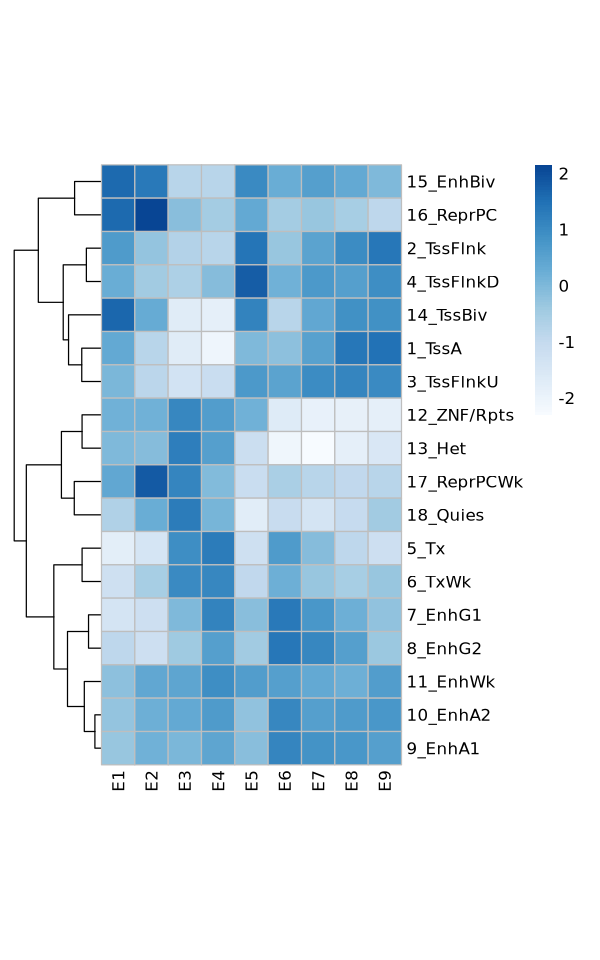

In [46]:
log2OE <- log2((obs_mat + 1) / (exp_mat + 1))

options(repr.plot.width = 5, repr.plot.height = 8)
t1 <- t(scale(t(log2OE))) %>% t %>%
pheatmap(scale = "none", cluster_rows = T, cluster_cols = F, display_numbers = F,
         angle_col = 90, # breaks = seq(-4, 4, 0.08), 
         cellwidth = 20, cellheight = 20,
         show_rownames = T, show_colnames = T, border_color = "grey", 
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(100))

## Annotate cCREs in each subclass

In [ ]:
### calculate in parallel
library(future.apply)

pair_df <- read.table("../06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = TRUE)
ccre    <- read.table("../07.cCREs/cCREs/hba.whole.union.peaks.bed")
range1  <- GRanges(ccre[,1], IRanges(ccre[,2], ccre[,3]), name = ccre[,4])
celltypes <- unique(pair_df$MiniAtlas)

## parallel setup
N_WORKERS <- 8  # or set a number you want
plan(multisession, workers = N_WORKERS)
data.table::setDTthreads(1)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1")

process_one <- function(f) {
  segf <- file.path(outdir, "DNAme_hyperCGN/segmentation", paste0(gsub("-", "_", f), "_9_segments.bed.gz")) 
    ### using unfiltered to make sure all the bins are accepted. 
  if (!file.exists(segf)) return(NULL)

  # fast gz read
  chmm <- fread(segf, header = FALSE, sep = "\t", showProgress = FALSE)
  if (ncol(chmm) < 4) return(NULL)
  range2 <- GRanges(chmm[[1]], IRanges(chmm[[2]], chmm[[3]]), state = chmm[[4]])

  dt <- intersect_wao(range1, range2) %>%
    setNames(c("chrom1","start1","end1","size1","strand1","ccre",
               "chrom2","start2","end2","size2","strand2","state","len")) %>%
    as.data.frame() %>%
    mutate(state = if_else(len == 0 & is.na(state), "mask", state))

  # collapse per cCRE × state
  res <- dt %>%
    group_by(ccre, chrom1, start1, end1, state) %>%
    summarise(len_state = sum(len), .groups = "drop_last") %>%
    mutate(sum_len = sum(len_state),
           ratio   = if_else(sum_len > 0, len_state / sum_len, 0),
           n_pos   = sum(len_state > 0)) %>%
    ungroup() %>%
    group_by(ccre, chrom1, start1, end1) %>%
    slice_max(order_by = ratio, n = 1, with_ties = FALSE) %>%
    mutate(rstate = case_when(
      ratio >= 0.5 ~ state,        # dominant state wins
      n_pos > 1    ~ "mix",        # no majority, multiple states → mix
      TRUE         ~ state
    )) %>%
    select(chrom1, start1, end1, ccre, state, ratio, rstate) %>%
    ungroup() %>%
    mutate(celltype = f)
    list(annolist = res)
}

### run future
parts <- future_lapply(celltypes, process_one, future.seed = TRUE)
parts <- parts[!vapply(parts, is.null, FALSE)]

annolist  <- dplyr::bind_rows(lapply(parts, `[[`, "annolist"))
saveRDS(annolist,  'output/DNAme_hyperCGN/annotation/hba.whole.union.peaks.annotation.unfilter.rds')

# reset plan
plan(sequential)

In [628]:
annolist2 <- alist <- list()
for (f in unique(annolist$celltype)){
    annolist2[[f]] <- annolist %>% filter(celltype == f) %>% select(chrom1, start1, end1, ccre, rstate, celltype) %>% distinct
    alist[[f]] <- table(annolist2[[f]]$rstate) %>% as.data.frame %>% tibble::column_to_rownames("Var1") %>% setNames(f)
}

In [629]:
saveRDS(annolist2, 'output/DNAme_hyperCGN/annotation/hba.whole.union.peaks.annotation.short.unfilter.rds')
saveRDS(alist,     'output/DNAme_hyperCGN/annotation/hba.whole.union.peaks.annotation.unfilter.summary.rds')

In [634]:
length(annolist2)
setdiff(corder, names(annolist2))
badcelltype <- c('IMMUNE' ,'ENDO', 'FBL', 'SST-CHODL', 'L5ET', 'MSN')

[1] 31

[1] "ACBGM" "MSN"   "CBGA"  "LRL"

In [43]:
### Only plot those that are defined as open
alist2 <- list()
for (f in unique(annolist$celltype)){
    ccre <- read.table(paste0("../07.cCREs/cCREs_w_H3K27ac/", f, "_w_H3K27ac.2state.bed"))
    qrange <- ccre$V4
    tmp <- annolist2[[f]]
    alist2[[f]] <- tmp %>% filter(ccre %in% qrange) %>% select(rstate) %>% table %>% as.data.frame %>% 
    tibble::column_to_rownames("rstate") %>% setNames(f)
}

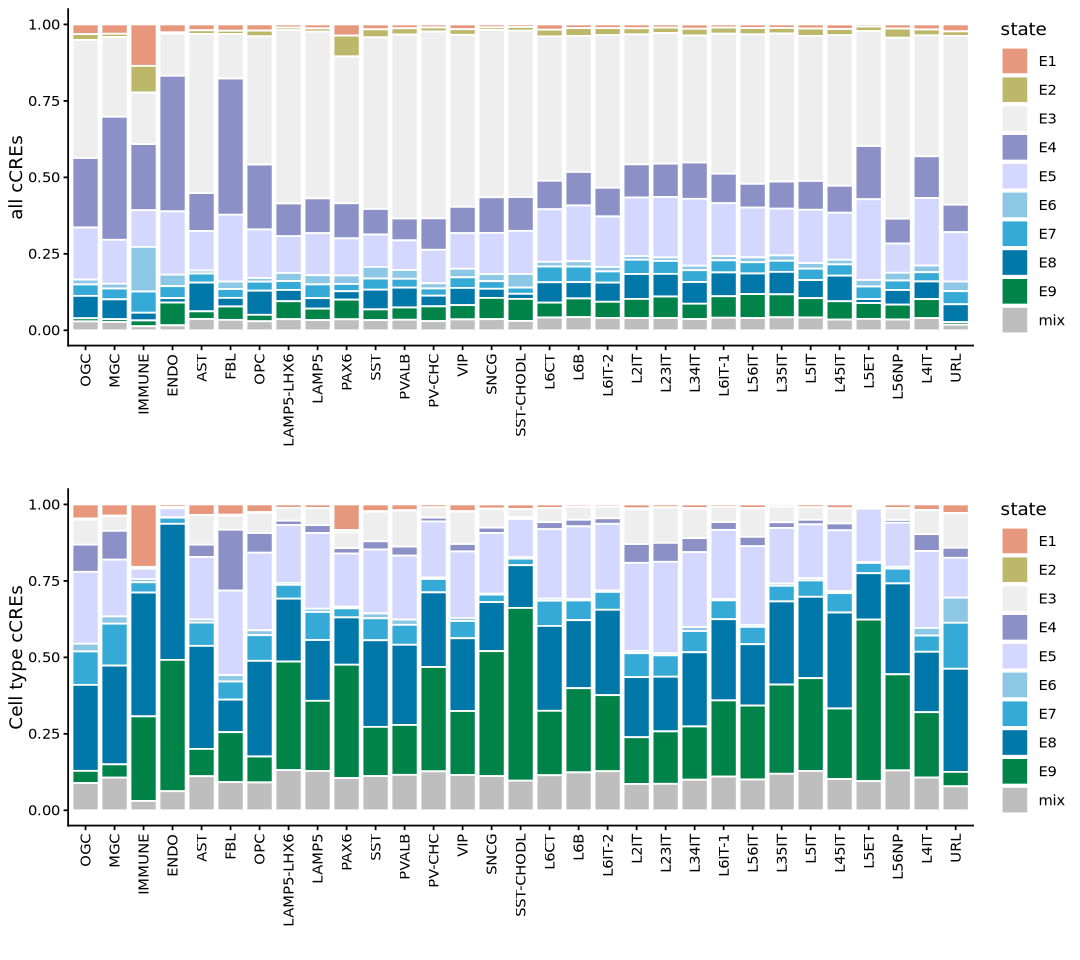

In [45]:
t1 <- do.call(cbind, alist) %>%
tibble::rownames_to_column("state") %>% filter(state != "mask") %>%
reshape2::melt(id.vars = "state") %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = variable, y = value, fill = state)) +
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + ylab("all cCREs") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = c(chmstate$color, "grey"))

t2 <- do.call(rbind, lapply(alist2, function(x) x %>% tibble::rownames_to_column('state') %>% reshape2::melt(id.vars = "state"))) %>%
filter(state != "mask") %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = variable, y = value, fill = state)) +
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + ylab("Cell type cCREs") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = c(chmstate$color, "grey"))

options(repr.plot.width = 9, repr.plot.height = 8)
fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)
fig1

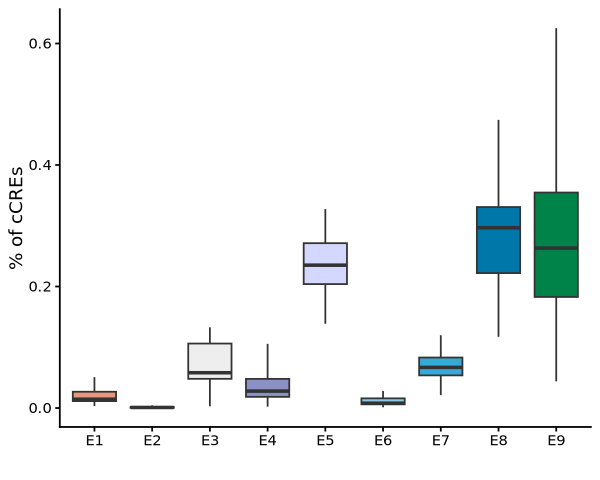

In [38]:
options(repr.plot.width = 5, repr.plot.height = 4)
t0 <- do.call(rbind, lapply(alist2, function(x) x %>% tibble::rownames_to_column('state') %>% reshape2::melt(id.vars = "state"))) %>%
filter(!(state %in% c("mix", "mask"))) %>%
group_by(variable) %>% mutate(ratio = value/sum(value)) %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = state, y = ratio, fill = state)) +
geom_boxplot(alpha = 1, coef = 2, outlier.shape = NA) + 
xlab("") + ylab("% of cCREs") +  
theme_classic() + 
scale_fill_manual(values = chmstate$color) + NoLegend()

t0
                            
ggsave(t0, filename = "../Figure/FIG_chromhmm_ct_cCREs_annotation_ratio.pdf", dpi = 300, width = 4, height = 4)

In [9]:
### calculate in parallel
library(future.apply)

pair_df <- read.table("../06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = TRUE)
ccre    <- read.table("../../ref/hba_snm3c/DMR/dmr.MajorType.rho08.dist250.filter1.repflt.bed")
range1  <- GRanges(ccre[,1], IRanges(ccre[,2], ccre[,3]), name = ccre[,4])
celltypes <- unique(pair_df$MiniAtlas)

## parallel setup
N_WORKERS <- 8  # or set a number you want
plan(multisession, workers = N_WORKERS)
data.table::setDTthreads(1)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1")

process_one <- function(f) {
  segf <- file.path(outdir, "DNAme_hyperCGN/segmentation", paste0(gsub("-", "_", f), "_9_segments.bed.gz")) 
  if (!file.exists(segf)) return(NULL)

  # fast gz read
  chmm <- fread(segf, header = FALSE, sep = "\t", showProgress = FALSE)
  if (ncol(chmm) < 4) return(NULL)
  range2 <- GRanges(chmm[[1]], IRanges(chmm[[2]], chmm[[3]]), state = chmm[[4]])

  dt <- intersect_wao(range1, range2) %>%
    setNames(c("chrom1","start1","end1","size1","strand1","ccre",
               "chrom2","start2","end2","size2","strand2","state","len")) %>%
    as.data.frame() %>%
    mutate(state = if_else(len == 0 & is.na(state), "mask", state))

  res <- dt %>%
    group_by(ccre, chrom1, start1, end1, state) %>%
    summarise(len_state = sum(len), .groups = "drop_last") %>%
    mutate(sum_len = sum(len_state),
           ratio   = if_else(sum_len > 0, len_state / sum_len, 0),
           n_pos   = sum(len_state > 0)) %>%
    ungroup() %>%
    group_by(ccre, chrom1, start1, end1) %>%
    slice_max(order_by = ratio, n = 1, with_ties = FALSE) %>%
    mutate(rstate = case_when(
      ratio >= 0.5 ~ state,        # dominant state wins
      n_pos > 1    ~ "mix",        # no majority, multiple states → mix
      TRUE         ~ state
    )) %>%
    select(chrom1, start1, end1, ccre, state, ratio, rstate) %>%
    ungroup() %>%
    mutate(celltype = f)
    list(annolist = res)
}

### run future
parts <- future_lapply(celltypes, process_one, future.seed = TRUE)
parts <- parts[!vapply(parts, is.null, FALSE)]

annolist  <- dplyr::bind_rows(lapply(parts, `[[`, "annolist"))
saveRDS(annolist,  'output/DNAme_hyperCGN/annotation/dmr.MajorType.rho08.dist250.filter1.repflt.annotation.unfilter.rds')

# reset plan
plan(sequential)

In [10]:
annolist2 <- alist <- list()
for (f in unique(annolist$celltype)){
    annolist2[[f]] <- annolist %>% filter(celltype == f) %>% select(chrom1, start1, end1, ccre, rstate, celltype) %>% distinct
    alist[[f]] <- table(annolist2[[f]]$rstate) %>% as.data.frame %>% tibble::column_to_rownames("Var1") %>% setNames(f)
}

saveRDS(annolist2, 'output/DNAme_hyperCGN/annotation/dmr.MajorType.rho08.dist250.filter1.repflt.annotation.short.unfilter.rds')
saveRDS(alist,     'output/DNAme_hyperCGN/annotation/dmr.MajorType.rho08.dist250.filter1.repflt.annotation.unfilter.summary.rds')

In [ ]:
t1 <- do.call(cbind, alist) %>%
tibble::rownames_to_column("state") %>% filter(state != "mask") %>%
reshape2::melt(id.vars = "state") %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = variable, y = value, fill = state)) +
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + ylab("all DMRs") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = c(chmstate$color, "grey"))

In [25]:
### Also get cell type assigned one:
### A DMR was assigned to a subtype if it was either CG hypomethylated in the subtype 
### (see “Determine differentially methylated regions” section above) or its CG-methylation level was <0.3
alist2 <- list()
for (f in unique(annolist$celltype)){
    f2 <- pair_df[pair_df$MiniAtlas == f,]$snm3c
    ccre <- read.table(paste0("../../ref/hba_snm3c/DMR/MajorType/", f2, ".DMR.bed"))
    qrange <- ccre$V4
    tmp <- annolist2[[f]]
    alist2[[f]] <- tmp %>% filter(ccre %in% qrange) %>% select(rstate) %>% table %>% as.data.frame %>% 
    tibble::column_to_rownames("rstate") %>% setNames(f)
}

t2 <- do.call(rbind, lapply(alist2, function(x) x %>% tibble::rownames_to_column('state') %>% reshape2::melt(id.vars = "state"))) %>%
filter(state != "mask") %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = variable, y = value, fill = state)) +
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + ylab("Cell type DMRs (ctf 0.3)") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = c(chmstate$color, "grey"))

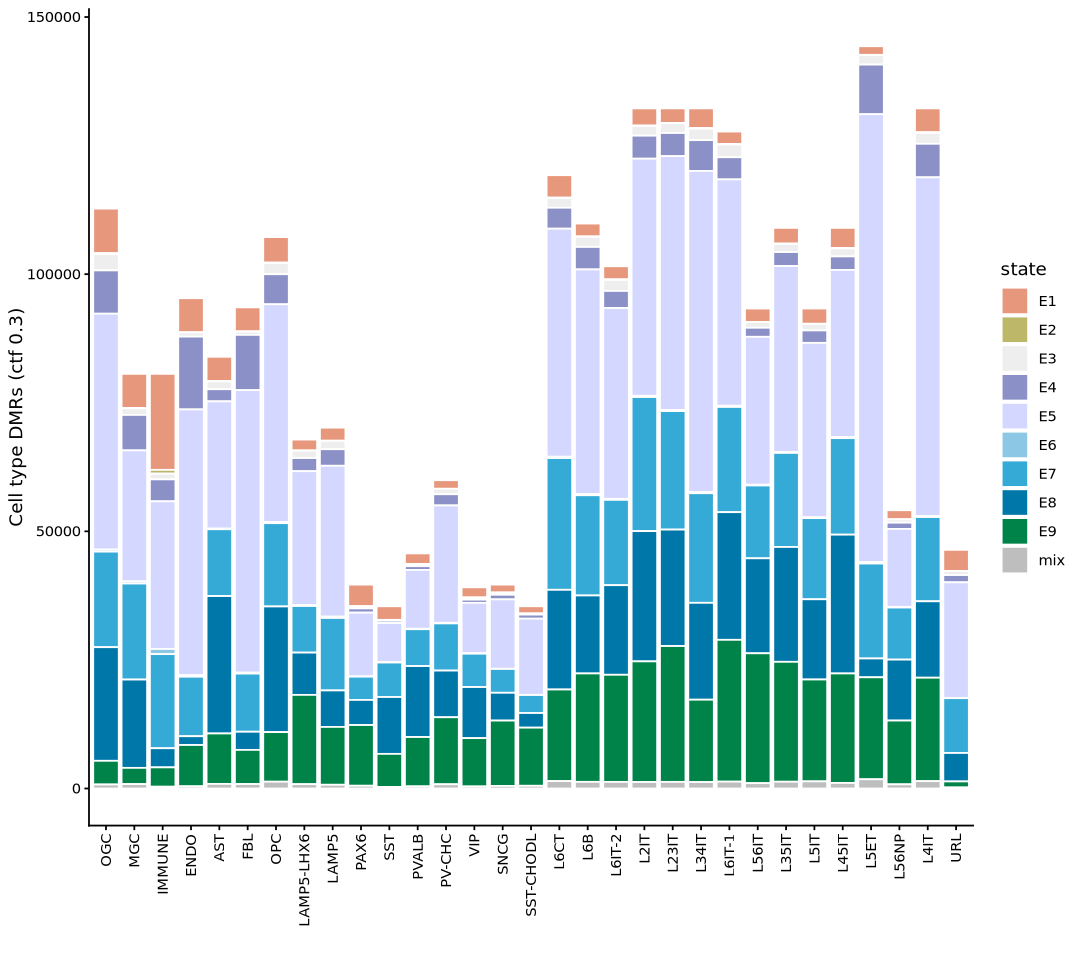

In [28]:
do.call(rbind, lapply(alist2, function(x) x %>% tibble::rownames_to_column('state') %>% reshape2::melt(id.vars = "state"))) %>%
filter(state != "mask") %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = variable, y = value, fill = state)) +
geom_col(position = "stack", color = "white") + 
theme_classic() + xlab("") + ylab("Cell type DMRs (ctf 0.3)") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = c(chmstate$color, "grey"))

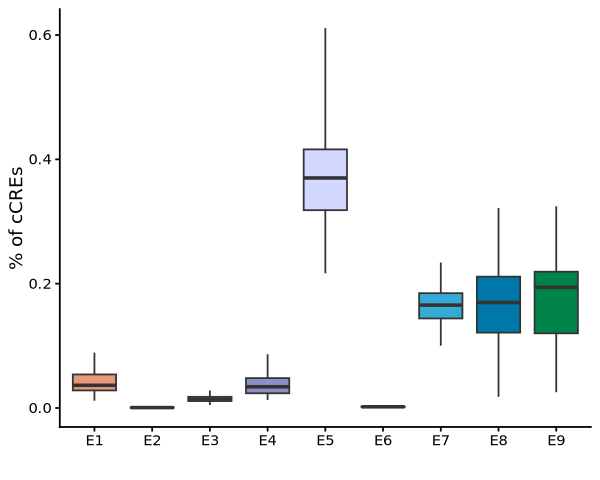

In [42]:
options(repr.plot.width = 5, repr.plot.height = 4)
t0 <- do.call(rbind, lapply(alist2, function(x) x %>% tibble::rownames_to_column('state') %>% reshape2::melt(id.vars = "state"))) %>%
filter(!(state %in% c("mix", "mask"))) %>%
group_by(variable) %>% mutate(ratio = value/sum(value)) %>%
mutate(variable = factor(variable, levels = corder)) %>% 
ggplot(aes(x = state, y = ratio, fill = state)) +
geom_boxplot(alpha = 1, coef = 2, outlier.shape = NA) + 
xlab("") + ylab("% of cCREs") +  
theme_classic() + 
scale_fill_manual(values = chmstate$color) + NoLegend()
                            
t0
                            
ggsave(t0, filename = "../Figure/FIG_chromhmm_ct_DMR_annotation_ratio.pdf", dpi = 300, width = 4, height = 4)

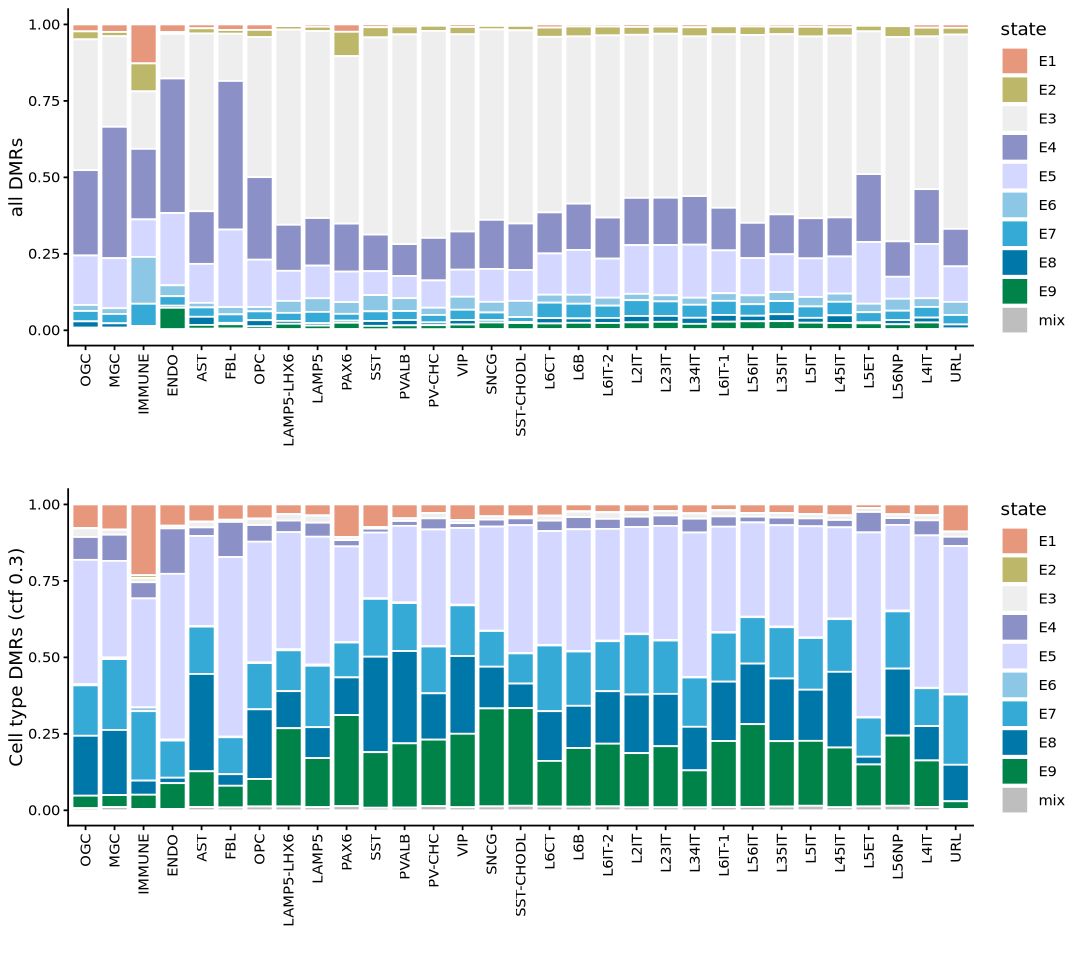

In [26]:
options(repr.plot.width = 9, repr.plot.height = 8)
fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)
fig1

In [27]:
ggsave(fig1, filename = "../Figure/FIG_chromhmm_all_DMR_annotation.pdf", dpi = 300, width = 9, height = 8)

In [4]:
### vista
vista <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/vista_enhancer_2024_locus.tsv", header = T)
gccod <- vista %>% filter(curation_status == "positive" & assembly == "hg38") %>% 
dplyr::select(coordinate_hg38) %>% unique %>% unlist
gccod <- stringr::str_split_fixed(gccod, pattern = "[:-]", n = 3) %>% as.data.frame
gccod <- gccod[grep("chr", gccod$V1),]
gcrange <- GRanges(gccod[,1], ranges = IRanges(as.numeric(gccod[,2]), as.numeric(gccod[,3])))

In [31]:
### Calculate overlap of each group with vista enhancer
slist <- list()
for (f in list.files("output/DNAme_hyperCGN/annotation/", pattern = "_hba.whole.union.peaks.anno.bed")){
    fname <- gsub("_hba.whole.union.peaks.anno.bed", "", f)
    # ccre <- read.table(paste0("../07.cCREs/cCREs_w_H3K27ac/", fname, "_w_H3K27ac.2state.bed")) 
    flist <- list()
    tmp <- read.table(paste0("output/DNAme_hyperCGN/annotation/", f)) # %>% filter(V4 %in% ccre$V4)
    trange <- GRanges(tmp[,1], ranges = IRanges(tmp[,2], tmp[,3]))
    idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(trange, gcrange)) %>% unique %>% length
    flist[["total"]] <- data.frame(ovlp = idx, uovlp = nrow(tmp) - idx, group = "total")
    for (state in unique(tmp$V5)){
        ttmp <- tmp %>% filter(V5 == state)
        srange <- GRanges(ttmp[,1], ranges = IRanges(ttmp[,2], ttmp[,3]))
        idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(srange, gcrange)) %>% unique %>% length
        flist[[state]] <- data.frame(ovlp = idx, uovlp = nrow(ttmp) - idx, group = state)
    }
    flist <- do.call(rbind, flist)
    odtable <- list()
    for (j in setdiff(unique(flist$group), "total")){
        tmtx <- flist[match(c(j, "total"), flist$group), ] %>% select(ovlp, uovlp) %>% as.matrix %>% t
        odtable[[j]] <- data.frame(pvalue = fisher.test(tmtx)$p.value, or = fisher.test(tmtx)$estimate, group = j, celltype = fname) 
    }
    slist[[fname]] <- do.call(rbind, odtable)
    slist[[fname]]$padi <- p.adjust(slist[[fname]]$pvalue, method = "BH")
}

slist <- do.call(rbind, slist)

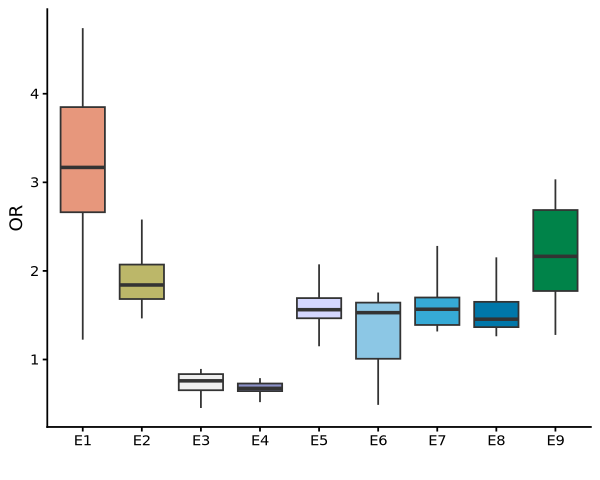

In [32]:
options(repr.plot.width = 5, repr.plot.height = 4)
slist %>% filter(padi < 0.05) %>%
ggplot(aes(x = group, y = or, fill = group)) + 
geom_boxplot(alpha = 1, coef = 2, outlier.shape = NA) + 
xlab("") + ylab("OR") +  
theme_classic() + 
scale_fill_manual(values = chmstate$color) + NoLegend()

In [644]:
### also plot signal enrichment in representative cell types
for (qct in names(annolist2)){
    system(paste0("mkdir -p output/DNAme_hyperCGN/segmentation/signal_enrich/", qct))
    segf <- read.table(paste0("output/DNAme_hyperCGN/segmentation/", gsub("-", "_", qct), "_9_segments.bed.gz")) %>% mutate(mid = floor((V2+V3)/2))
    for (f in unique(segf$V4)){
        tmp <- segf %>% filter(V4 == f) %>% mutate(V2 = as.integer(mid), V3 = as.integer(mid+1))
        write.table(tmp[,c("V1", "V2", "V3", "V4")], paste0("output/DNAme_hyperCGN/segmentation/signal_enrich/", qct, "/", f, ".bed"), 
                    row.names = F, col.names = F, sep = "\t", quote = F)
    }
}

In [648]:
suppressPackageStartupMessages(library(profileplyr))
dmtx <- import_deepToolsMat("output/DNAme_hyperCGN/segmentation/signal_enrich/PVALB/PVALB_heatmap.mtx.gz")

In [651]:
# generateEnrichedHeatmap(dmtx)
gc()

used       (Mb)    gc trigger  (Mb)     max used    (Mb)    
Ncells   17270960   922.4  2332016060 124543.1  1672190518  89304.7
Vcells 3089712489 23572.7 14835463412 113185.7 18544328927 141482.1

### Identify eQTL chromatin states

In [ ]:
dlist <- list()
outdir <- "/projects/ps-renlab2/y2xie/projects/BICAN/analysis/10.chromhmm/output/"
for (f in list.files("../../ref/Jang2025_SingleBrain/", pattern = ".*.bedpe")){
    fname <- gsub("_eqtl_top_assoc.top_assoc.bedpe", "", f)
    tdf <- read.table(paste0("../../ref/Jang2025_SingleBrain/", f))
    trange <- GRanges(tdf[,1], ranges = IRanges(as.integer(tdf[,2]), as.integer(tdf[,3])))
    for (f2 in list.files(paste0(outdir, "DNAme_hyperCGN/segmentation/"), pattern = ".*_9_segments.bed.gz")){
        ct <- gsub("_9_segments.bed.gz", "", f2)
        chmm <- read.table(paste0(outdir, "DNAme_hyperCGN/segmentation/", f2))
        crange <- GRanges(chmm[,1], ranges = IRanges(as.integer(chmm[,2]), as.integer(chmm[,3])), state = chmm[,4])
        dlist[[paste0(fname, ":", ct)]] <- findOverlapPairs(trange, crange) %>% as.data.frame %>% 
        select(first.seqnames, first.start, first.end, second.X.state) %>% distinct %>%
        mutate(qtl_ct = fname, chmm_ct = ct)
    }
}

In [26]:
saveRDS(dlist, "Jang2025_SingleBrain_eQTL_chmm_annotation.rds")

In [32]:
slist <- do.call(rbind, lapply(dlist, function(x) x %>% add_count(second.X.state, name = "freq") %>% 
select(second.X.state,qtl_ct,chmm_ct,freq) %>%
distinct))

In [37]:
korder <- c("OD", 'MG', 'Ast', 'OPC',
  'IN1', 'IN2', 'IN3', 'IN6', 'IN4', 'IN7', 'IN5', 
  'Ext6', 'Ext5', 'Ext7', 'Ext1', 'Ext8', 'Ext2', 'Ext4', 'Ext3')

corder3 <- c("OGC", 'MGC', 'AST', 'OPC',
  'LAMP5_LHX6', 'LAMP5', 'PAX6', 'SST', 'PVALB', 'VIP', 'SNCG', 
  'L6CT', 'L6B', 'L6IT_2', 'L2IT', 'L23IT', 'L6IT_1', 'L34IT', 'L35IT', 'L45IT', 'L4IT', 'L5IT', 'L56NP')

plist <- list()
for (f1 in korder){
    for (f2 in corder3){
        plist[[paste0(f1, ":", f2)]] <- slist %>% filter(qtl_ct == f1, chmm_ct == f2) %>%
        ggplot(aes(x = "", y = freq, fill = second.X.state)) + 
        geom_bar(width = 1, stat = "identity", color = "white") +
        coord_polar(theta = "y") + 
        theme_void() + 
        scale_fill_manual(values = chmstate$color) + NoLegend()
    }
}
length(plist)

[1] 437

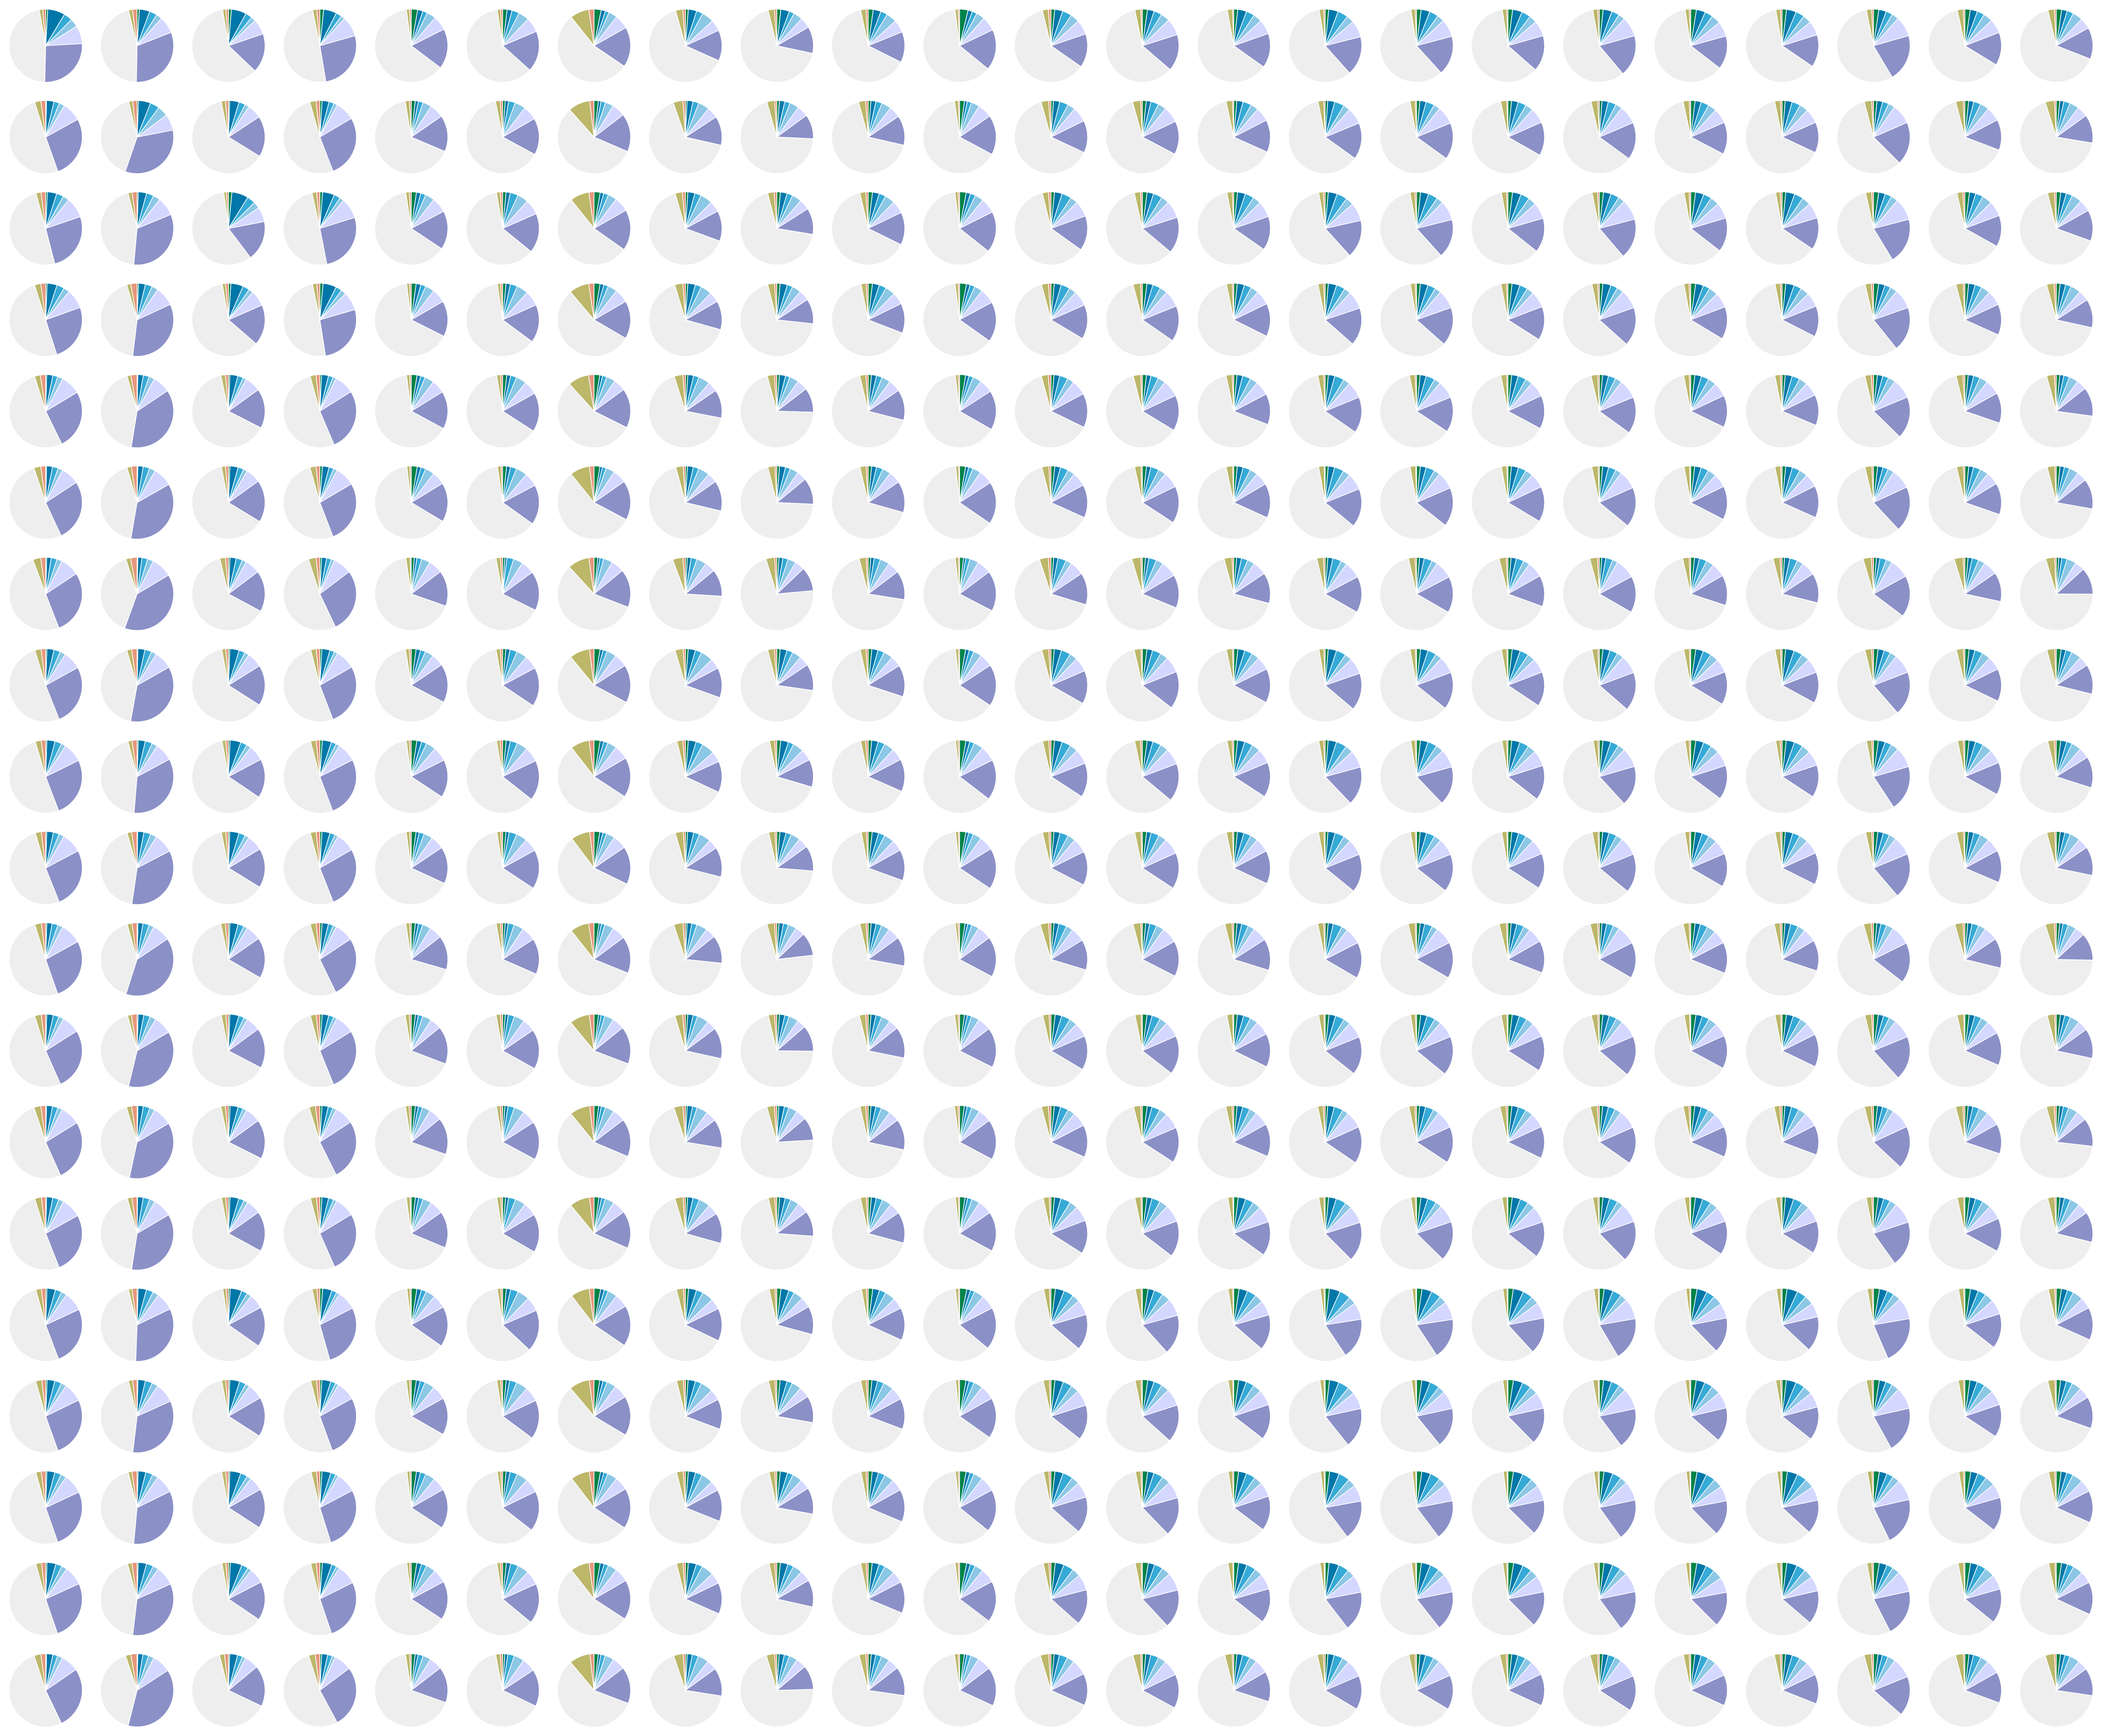

In [39]:
options(repr.plot.width = 46, repr.plot.height = 38)
fig1 <- cowplot::plot_grid(plotlist = plist, ncol = length(corder3), nrow = length(korder))
fig1

In [40]:
ggsave(fig1, filename = "Jang2025_eQTL_celltype_by_MiniAtlas_subclass.pdf", dpi = 300, height = 39, width = 46)

In [59]:
korder2 <- c("OD", 'MG', 'Ast', 'OPC', 'IN', 'Ext')
# plist2 <- list()
# for (f1 in korder){
#     for (f2 in corder3){
#         plist2[[paste0(f1, ":", f2)]] <- slist %>% filter(qtl_ct == f1, chmm_ct == f2) %>%
#         ggplot(aes(x = "", y = freq, fill = second.X.state)) + 
#         geom_bar(width = 1, stat = "identity", color = "white") +
#         coord_polar(theta = "y") + 
#         theme_void() + 
#         scale_fill_manual(values = chmstate$color) + NoLegend()
#     }
# }
# length(plist2)

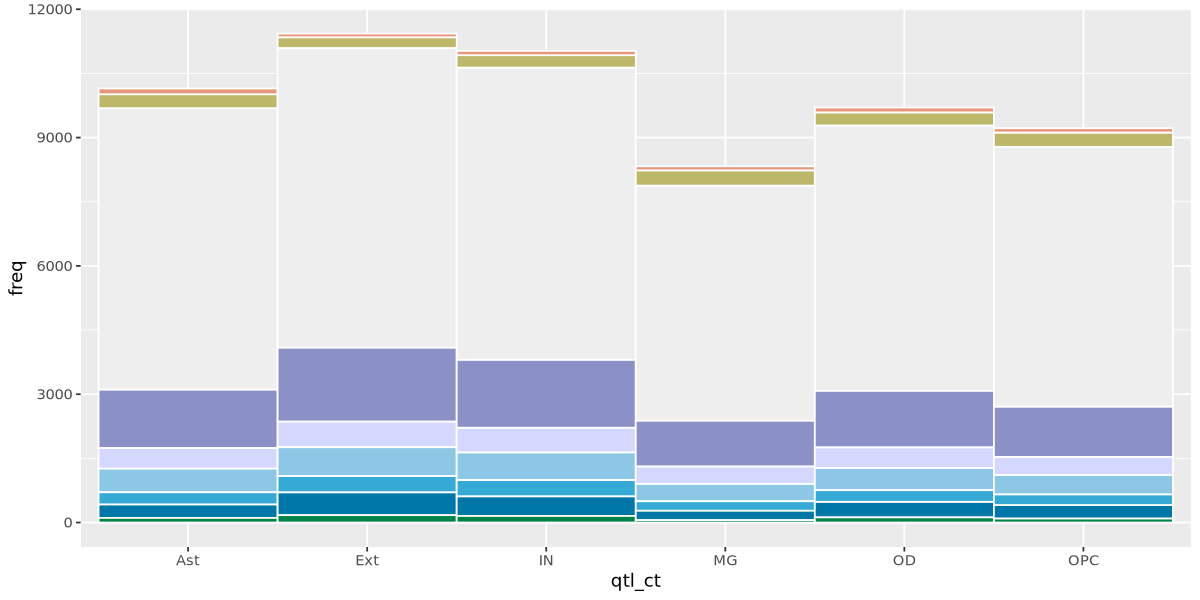

In [63]:
options(repr.plot.width = 10, repr.plot.height = 5)
slist %>% filter(qtl_ct %in% korder2, chmm_ct == "SST") %>%
ggplot(aes(x = qtl_ct, y = freq, fill = second.X.state)) + 
geom_bar(width = 1, stat = "identity", color = "white") +
scale_fill_manual(values = chmstate$color) + NoLegend()

In [49]:
plist <- list()
for (f1 in korder){
    for (f2 in corder3){
        plist[[paste0(f1, ":", f2)]] <- slist %>% 
        filter(qtl_ct == f1, chmm_ct == f2) %>%
        mutate(ratio = freq/sum(freq)) %>%
        filter(second.X.state %in% c('E6', 'E7', 'E8')) %>%
        summarise(ratio = sum(ratio), qtl_ct = unique(qtl_ct), chmm_ct = unique(chmm_ct)) %>%
        select(ratio, qtl_ct,chmm_ct)
    }
}
plist <- do.call(rbind, plist)

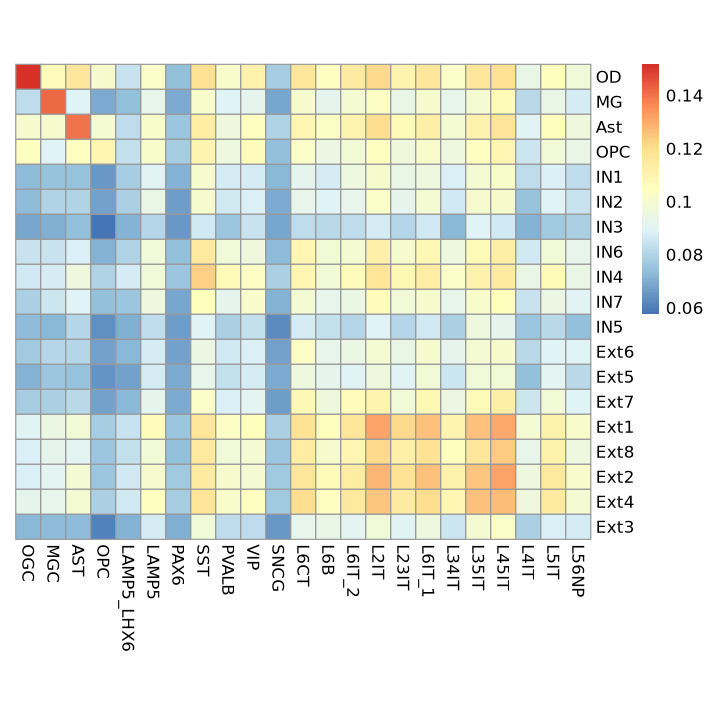

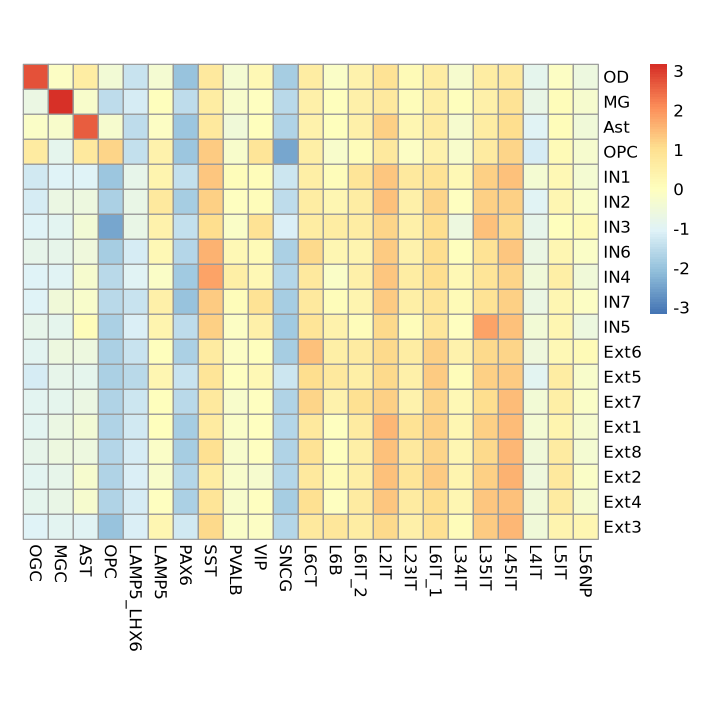

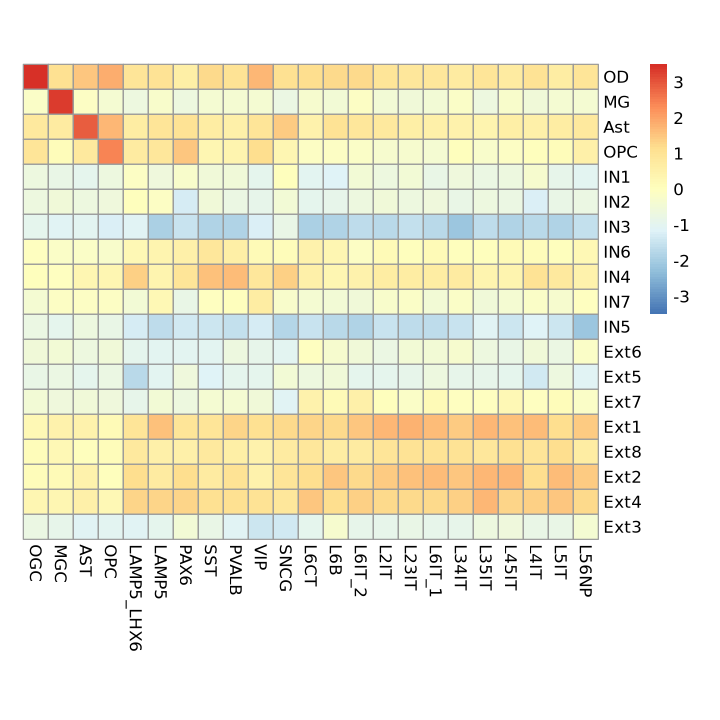

In [53]:
options(repr.plot.width = 6, repr.plot.height = 6)
mtx <- plist %>% reshape2::dcast(qtl_ct ~ chmm_ct, value.var = 'ratio') %>%
tibble::column_to_rownames('qtl_ct')

mtx[korder, corder3] %>%
pheatmap(cluster_rows = F, cluster_cols = F, cellheight = 15, cellwidth = 15)

mtx[korder, corder3] %>%
pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, cellheight = 15, cellwidth = 15)

mtx[korder, corder3] %>%
pheatmap(scale = "column", cluster_rows = F, cluster_cols = F, cellheight = 15, cellwidth = 15)

## Plot shift of chromatin states between comparble cell subclasses

In [23]:
b1 <- read.table("../07.cCREs/cCREs/subclass/OGC.bed")
b2 <- read.table("../07.cCREs/cCREs/subclass/OPC.bed")
unique(c(b1$V4, b2$V4)) %>% length

[1] 174893

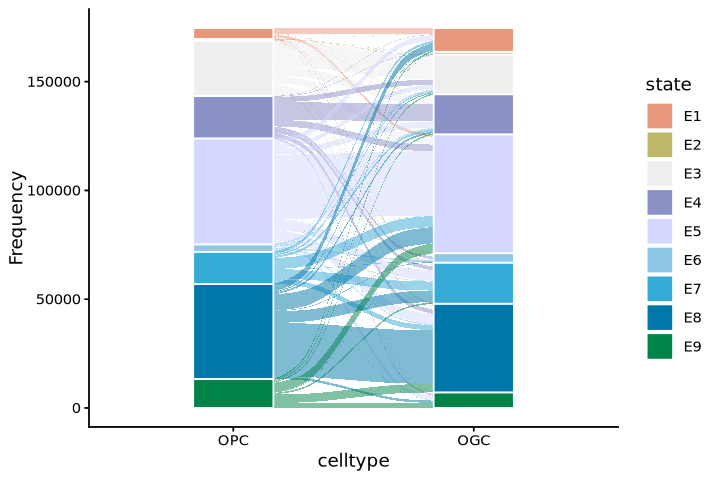

In [29]:
t1 <- annolist %>% filter(celltype %in% c("OGC", "OPC")) %>%
filter(ccre %in% unique(c(b1$V4, b2$V4))) %>%
filter(state != "mask") %>% 
reshape2::dcast(ccre ~ celltype, value.var = "state") %>%
tibble::column_to_rownames("ccre") %>%
count(across(everything())) %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = starts_with("O"), names_to = "celltype", values_to = "state") %>%
mutate(celltype = factor(celltype, levels = c("OPC", "OGC"))) %>%
ggplot(aes(x = celltype, stratum = state, alluvium = id, y = n, fill = state)) +
geom_flow() + ylab("Frequency") + 
geom_stratum(color = "white") +
NoLegend() + theme_classic() + 
scale_fill_manual(values = c(chmstate$color)) # + NoLegend()

options(repr.plot.width = 6, repr.plot.height = 4)
t1